# Parameter Estimation
First get handle to example model file:

In [1]:
import os,glob
import site
site.addsitedir(r'/home/b3053674/Documents/PyCoTools')
import PyCoTools
from PyCoTools.PyCoToolsTutorial import test_models

%matplotlib inline
TM = test_models.TestModels()
kholodenko_string = TM.get_kholodenko_variant1()
dire = '/home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial'
kholodenko_model = os.path.join(dire, 'kholodenko_model.cps')

with open(kholodenko_model, 'w') as f:
    f.write(kholodenko_string)

print (kholodenko_model)
print (os.path.isfile(kholodenko_model))

INFO:root:__init__:<module>:26:Initializing PyCoTools
INFO:root:__init__:<module>:27:Initializing logging System
INFO:root:__init__:<module>:28:logging config file at: /home/b3053674/Documents/PyCoTools/PyCoTools/logging_config.conf
/home/b3053674/Documents/PyCoTools/PyCoTools/PyCoToolsTutorial/kholodenko_model.cps
True


Now simulate some synthetic data for sake of running an example. See the TimeCourse tutorial for details. 

In [2]:
import site
site.addsitedir(r'C:\Users\Ciaran\Documents\PyCoTools')
import PyCoTools,pandas
report= 'parameter_estimation_synthetic_data.txt'
TC=PyCoTools.pycopi.TimeCourse(kholodenko_model,start=0,end=1000,intervals=1000,step_size=1,
                            report_name = report)

## validate that its worked
print (pandas.read_csv(TC['report_name'],sep='\t').head())

## Give fake data a meaningful name
data1 = TC['report_name']

   Time  [Mek1-PP]   [Erk2]    [Mos]  [Erk2-P]  [Erk2-PP]  [Mos-P]   [Mek1]  \
0     0   10.00000  280.000  90.0000   10.0000   10.00000  10.0000  280.000   
1     1    9.80684  279.966  89.0736   10.1341    9.90002  10.9264  280.053   
2     2    9.62736  279.938  88.1478   10.2622    9.80014  11.8522  280.087   
3     3    9.46152  279.915  87.2222   10.3845    9.70043  12.7778  280.101   
4     4    9.30931  279.898  86.2964   10.5014    9.60098  13.7036  280.096   

   [Mek1-P]  Values[Mek_tot]  Values[Erk_tot]  Values[Erk-P_tot]  \
0   10.0000              300              300            20.0000   
1   10.1402              300              300            20.0342   
2   10.2861              300              300            20.0623   
3   10.4378              300              300            20.0850   
4   10.5951              300              300            20.1024   

   Values[Mos-P_tot]  Values[Mek-P_tot]  Values[Mos_tot]  
0            10.0000            20.0000              100 

Note that it is completely necessary to have column headings in a data file that exactly match a model variable. Independant variables can be mapped easily by appending the suffic `'_indep'` to the variable. If you had two data sets that stimulated cell cultures at different concentrations for example, you could have `stimulation_indep` as a column heading in both with each containing the amount of stimulant that was used in the experiment. 

# Setup and run single parameter estimation 
Now we're ready to setup and run a parameter estimation

In [ ]:
import PyCoTools, os
PE=PyCoTools.pycopi.ParameterEstimation(kholodenko_model,data1)

The behaviour of the parameter estimation can be using keyword arguments. For example, to change the optimization algorithm, add the `method` argument:

In [ ]:
PE=PyCoTools.pycopi.ParameterEstimation(kholodenko_model,data1,
                                        method='HookeJeeves')

All algorithm specific parameters should be defined here here as well. Take a look at the GUI to see which parameters exist (i.e. swarm size in particle swarm). 

In [ ]:
PE=PyCoTools.pycopi.ParameterEstimation(kholodenko_model,data1,
                                        method='HookeJeeves',
                                        iteration_limit = 100,
                                        tolerance = 1e-10,
                                        plot=True)

## sanity check
print ('tolerance = ',PE['tolerance'])
print ('iteration_limit =', PE['iteration_limit'])

Now use the `write_config_template` method to create a parameter estimation configuration file specific for your model:

In [ ]:
PE.write_config_template()

The filename can user specified by passing an argument to the `ConfigFilename` kwarg on instantiation. Here we use the default:

In [ ]:
## check that the config filename exists
print (os.path.isfile(PE.kwargs['config_filename']))
print ('Your config file is here: {}'.format(PE.kwargs['config_filename']))

A parameter estimation configuration file has 7 columns but the last three are not meant to be modified in any way. Each row corresponds to a parameter in your model and by default all kinetic parameters (local and global) and initial concentration parameters are included in the configuration. To exclude a parameter from the estimation simply delete the row corresponding to the parameter you wish to remove. Also, specify the estimation boundaries for each parameter and optionally the starting value. It is common to randomize the start values which by default is True (i.e. `randomize_start_vales = True`) . If you would like to use the configuration file as to specify start values then you must set the `use_template_start_values` option to `True`. 

After modification, save and close the file. In the example, no modifications we're made and so all kinetic and initial concentration parameters are estimated. 

Now use the `setup()` and `run()` methods. 

In [ ]:
PE.setup()

Open the model and check the parameter estimation task (optionally run the next cell). The ParameterEstimation class has performed the configuration. 

In [ ]:
import os
os.system('CopasiUI {}'.format(kholodenko_model))
##  remember to close the model before continuing

The `run()` method will run the copasi file using `CopasiSE` behind the scenes. 

In [ ]:
PE.run() # will take some time

The `run()` method should take a bit of time and the output will be the parameter parmeters.

In [ ]:
import pandas
import matplotlib.pyplot as plt
import numpy
## lets take a look at the parameter estimation results
pe_data= pandas.read_csv(PE.kwargs['report_name'],sep='\t') 

print 'These are your estimated parameters:\n\n{}'.format(pe_data.transpose())

## Multiple Data Files
PyCoTools can easily handle multiple data files by giving `ParameterEsimation` a list of data file paths. Lets simulate some more data.

Lets first change a model parameter so both sets of simulated data are not identical:

In [ ]:
import PyCoTools,os
## Original value of Mek1-PP at time 0 is 10 (though your previous estimations may have changed it)
GMQ=PyCoTools.pycopi.GetModelQuantities(kholodenko_model)
print 'Old parameter value: {}'.format(GMQ.get_IC_cns()['Mek1-PP']['concentration'])

#Use InsertParameters to change it to 20
I=PyCoTools.pycopi.InsertParameters(kholodenko_model,parameter_dict={'Mek1-PP':20})
GMQ=PyCoTools.pycopi.GetModelQuantities(kholodenko_model)
print 'New Parameter Value: {}'.format(GMQ.get_IC_cns()['Mek1-PP']['concentration'])



And Simulate some data:

In [ ]:
import PyCoTools,pandas
report= 'parameter_estimation_synthetic_data2.txt'
TC=PyCoTools.pycopi.TimeCourse(kholodenko_model,
                               end=1000,
                               intervals=10,
                               step_size=100,
                               report_name = report,
                               plot=True)


## Give fake data a meaningful name
data2 = TC.kwargs['report_name']

Now setup a parameter estimation like before and run. Note that we already have a configuration file with the default filename and therefore do not need to rewrite one. 

In this parameter estimation we know that the difference between the two data sets is the initial concentration of 'Mek1-PP'. Usually in a parameter estimation this would be mapped to a COPASI independent variable by adding another column in any data files. See the [doc](http://copasi.org/Support/User_Manual/Tasks/Parameter_Estimation/Experimental_Data/) for more on independent valiables. To implement independ variables with PyCoTools, append the suffix '_indep' onto the back of the variable name (i.e. here 'Mek1-PP_indep') and the mapping will automatically be to the independent variable. This is not done here for brevity. 

In [ ]:
from PyCoTools.pycopi import ParameterEstimation 

report = 'parameter_estimation_data2.txt'
PE=ParameterEstimation(kholodenko_model,[data1,data2],method='GeneticAlgorithm',plot=True,
                       population_size = 50,number_of_generations= 300,report_name = report)

PE.write_config_template()
PE.setup()
PE.run()
PE.format_results()

os.system('CopasiUI {}'.format(kholodenko_model))

INFO:PyCoTools.pycopi:pycopi:check_parameter_consistancy:5001:Model parameter names: set(['Erk-P_tot', 'Erk_tot', '(phosphorylation of MAPKK).KK3', '(MAPKKK activation).K1', 'Erk2-P', '(dephosphorylation of MAPK-PP).V9', 'Mos-P', '(phosphorylation of MAPK).k7', 'Mos-P_tot', 'Mos_tot', '(phosphorylation of MAPK-P).k8', '(MAPKKK inactivation).KK2', '(MAPKKK inactivation).V2', 'Mos', 'Mek_tot', 'Erk2-PP', '(phosphorylation of MAPKK).k3', '(phosphorylation of MAPKK-P).k4', '(dephosphorylation of MAPKK-PP).KK5', 'uVol', '(phosphorylation of MAPK-P).KK8', '(dephosphorylation of MAPK-PP).KK9', '(dephosphorylation of MAPKK-P).KK6', '(phosphorylation of MAPKK-P).KK4', 'Erk2', '(MAPKKK activation).V1', '(MAPKKK activation).Ki', 'Mek-P_tot', '(phosphorylation of MAPK).KK7', '(dephosphorylation of MAPK-P).KK10', 'Mek1-PP', '(dephosphorylation of MAPKK-PP).V5', '(dephosphorylation of MAPK-P).V10', 'Mek1', 'Mek1-P', '(dephosphorylation of MAPKK-P).V6', '(MAPKKK activation).n'])
INFO:PyCoTools.pycopi

ValueError: Length mismatch: Expected axis has 30 elements, new values have 31 elements

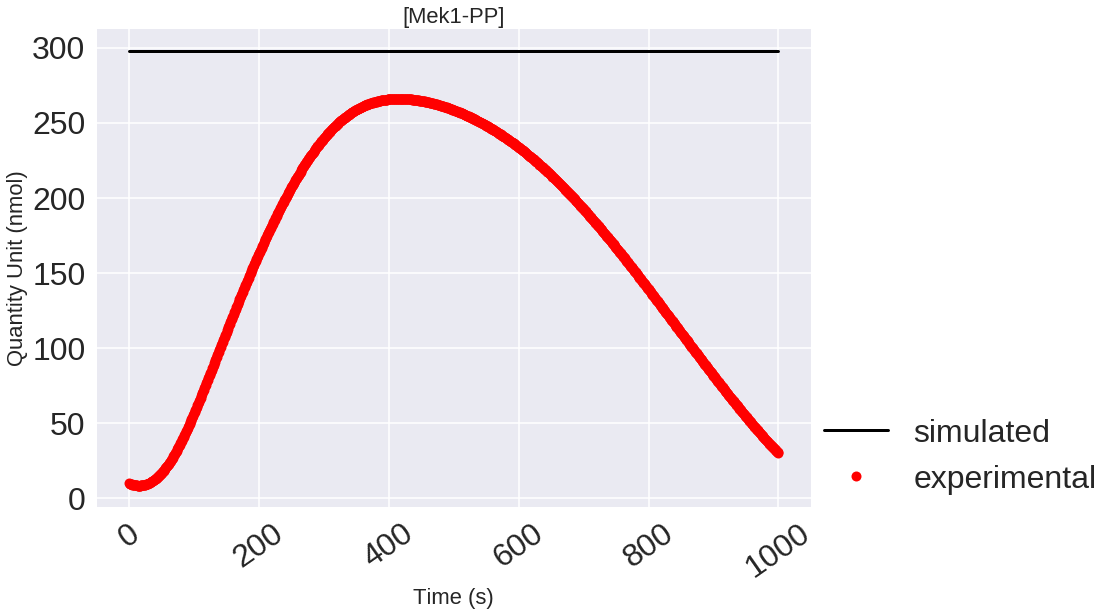

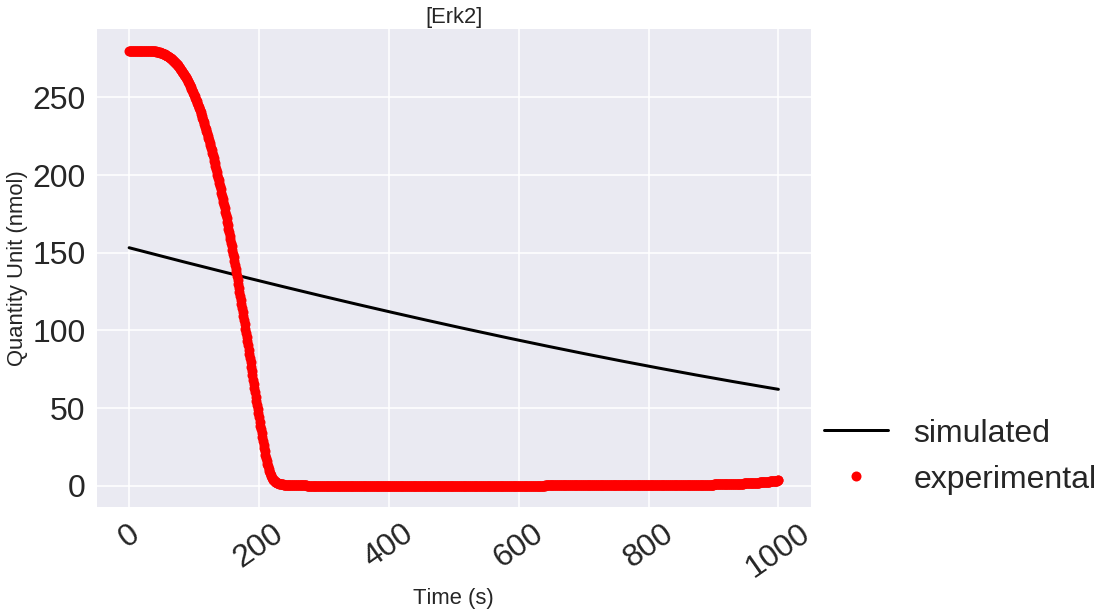

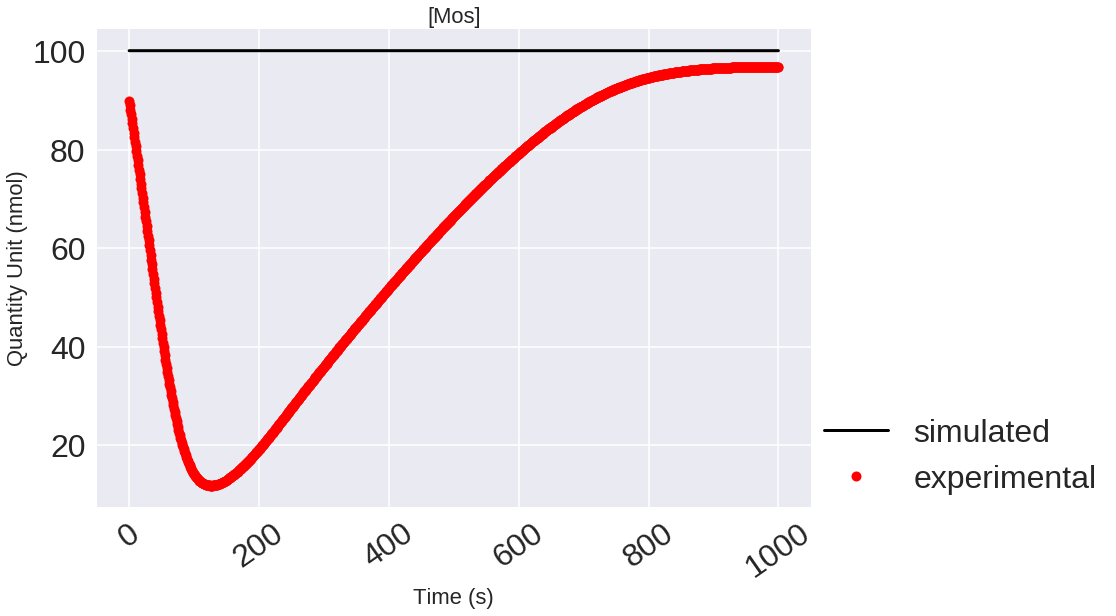

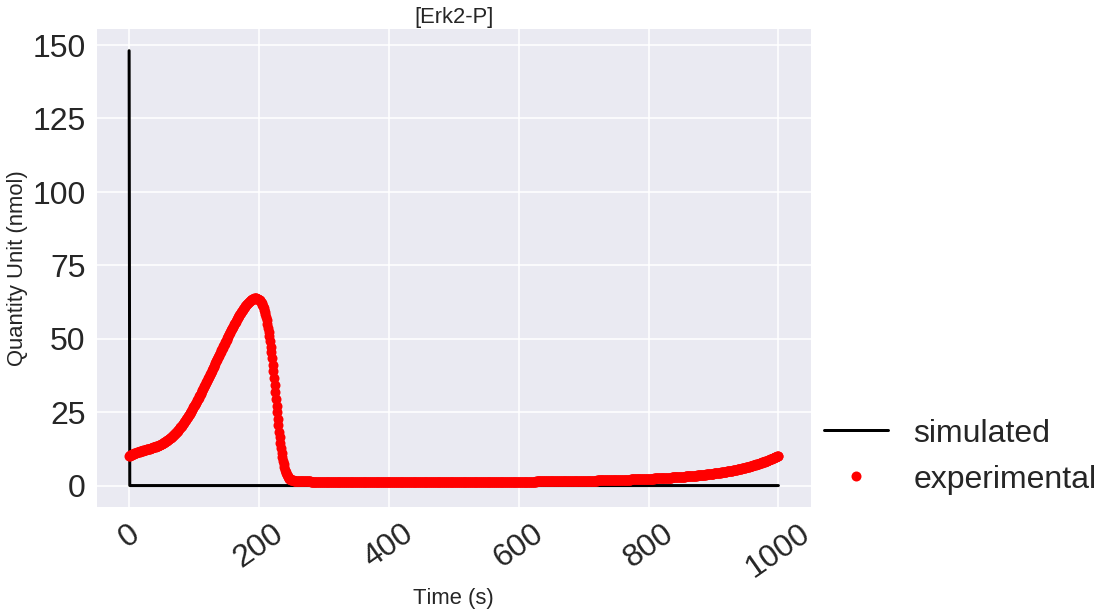

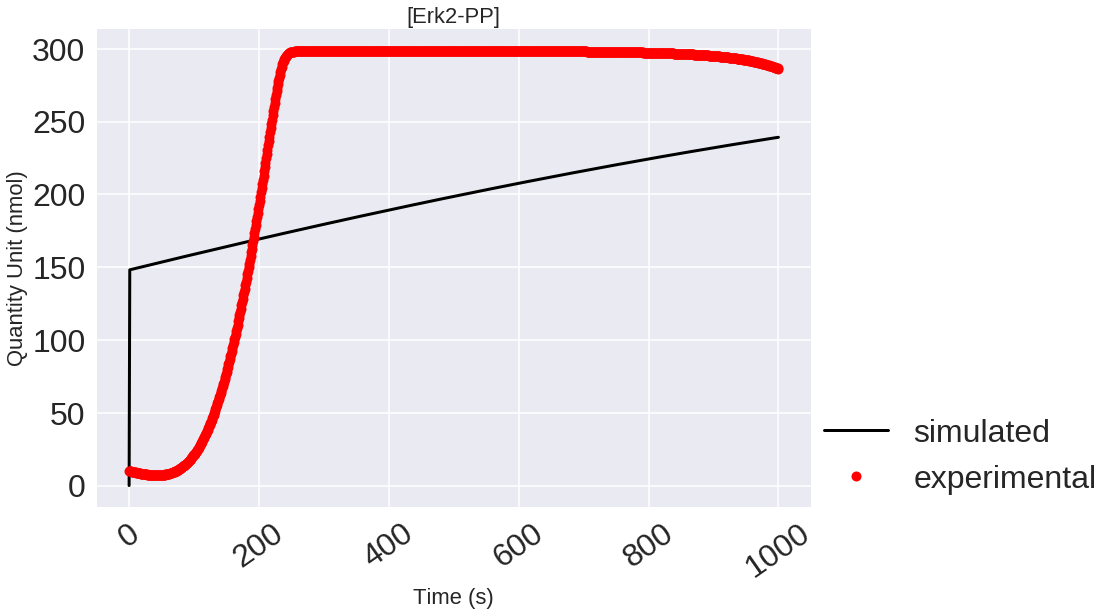

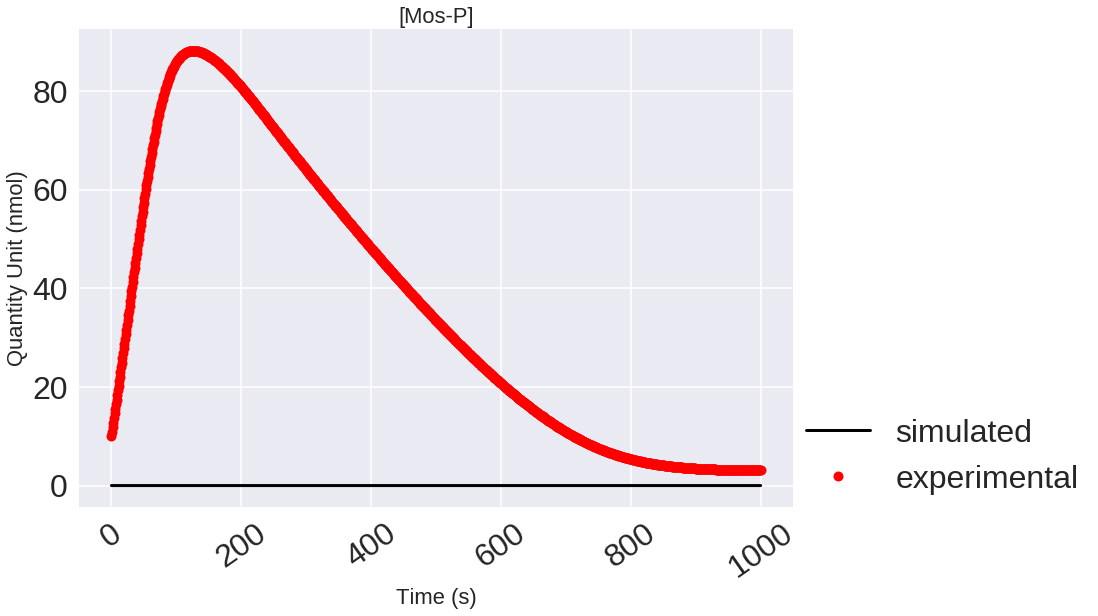

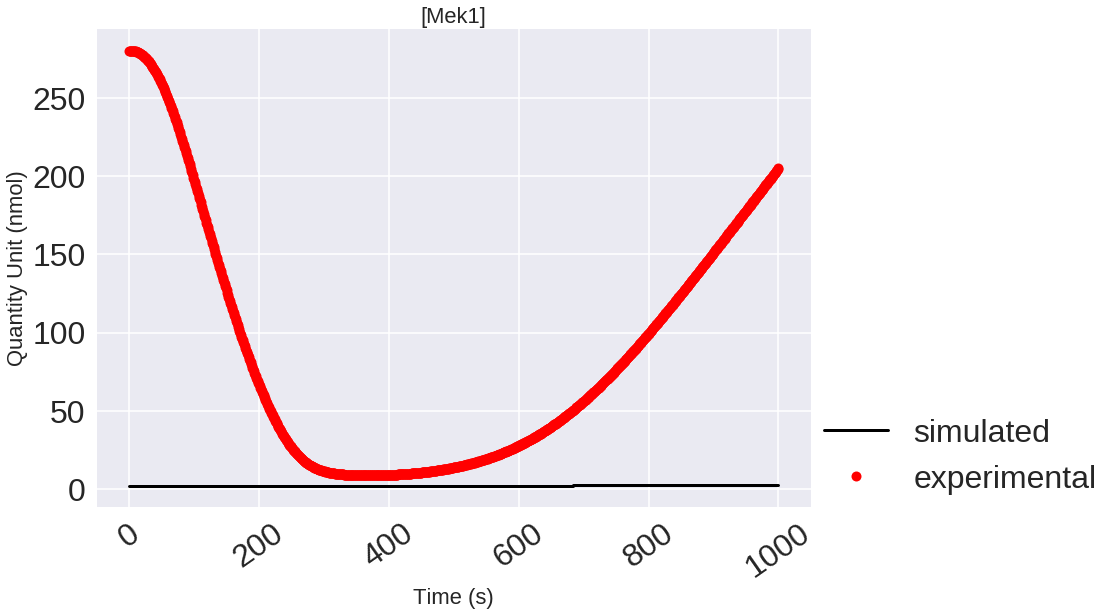

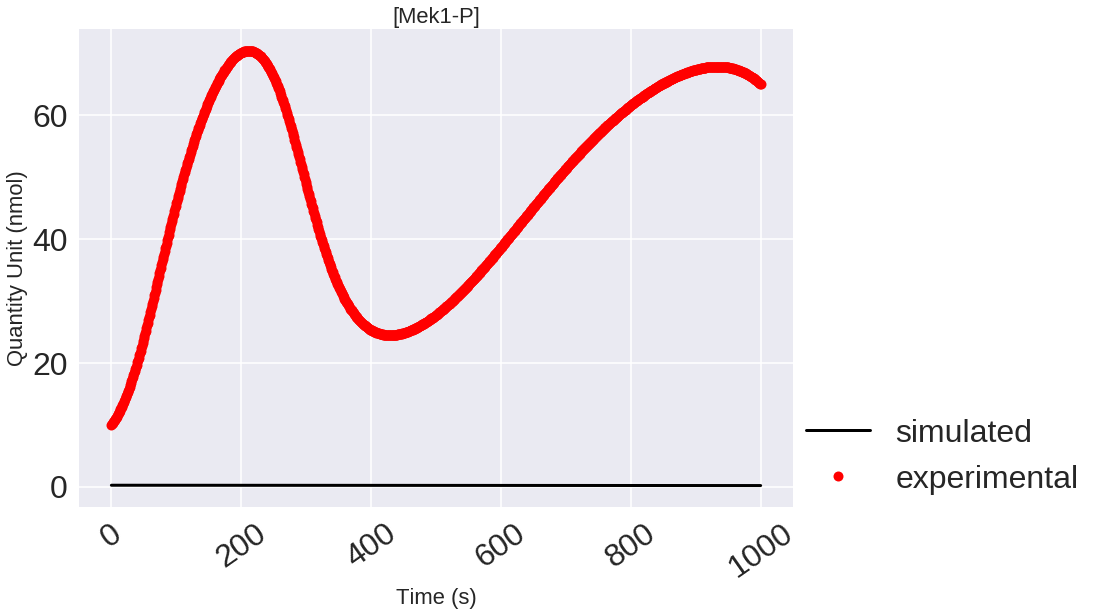

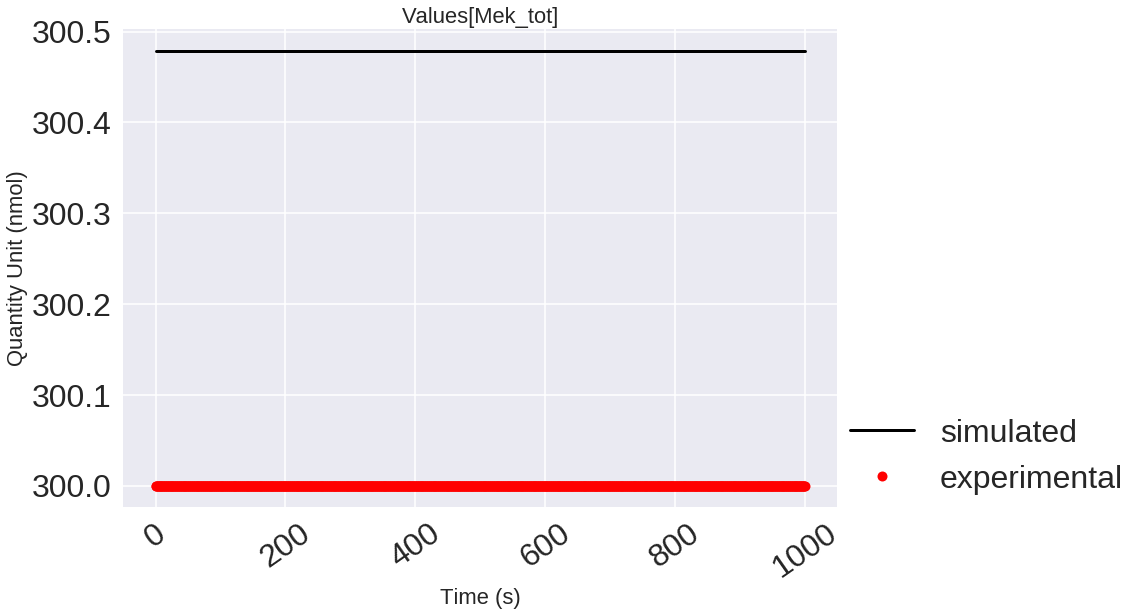

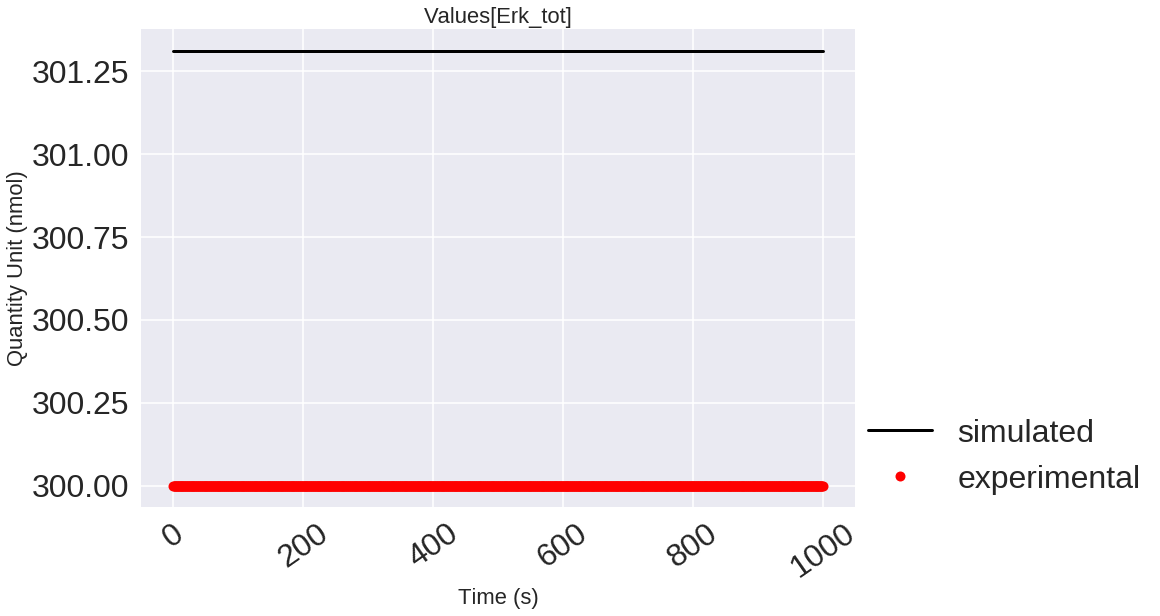

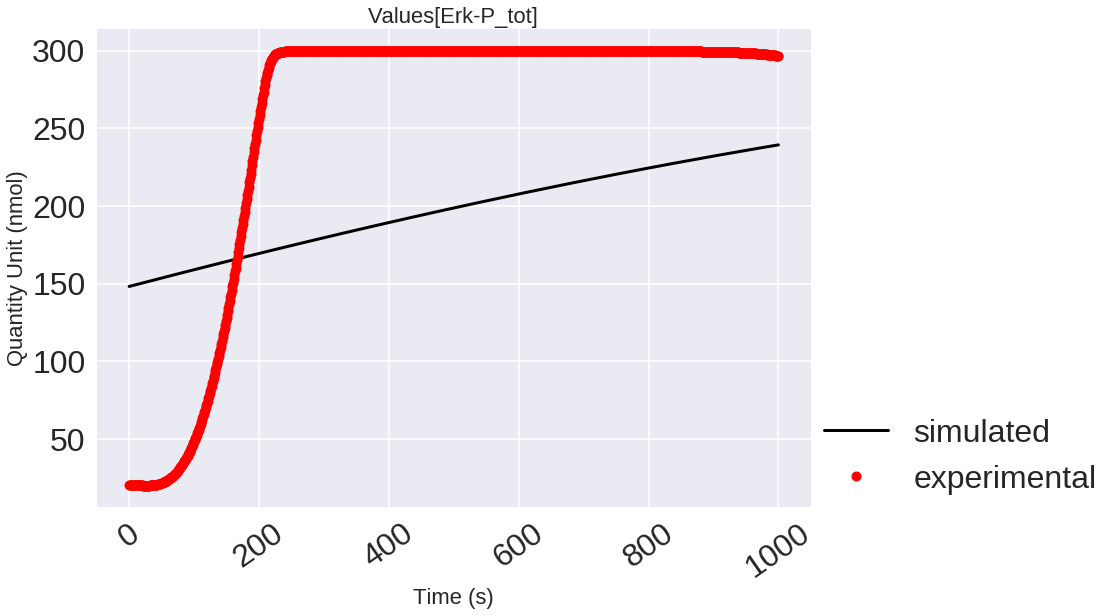

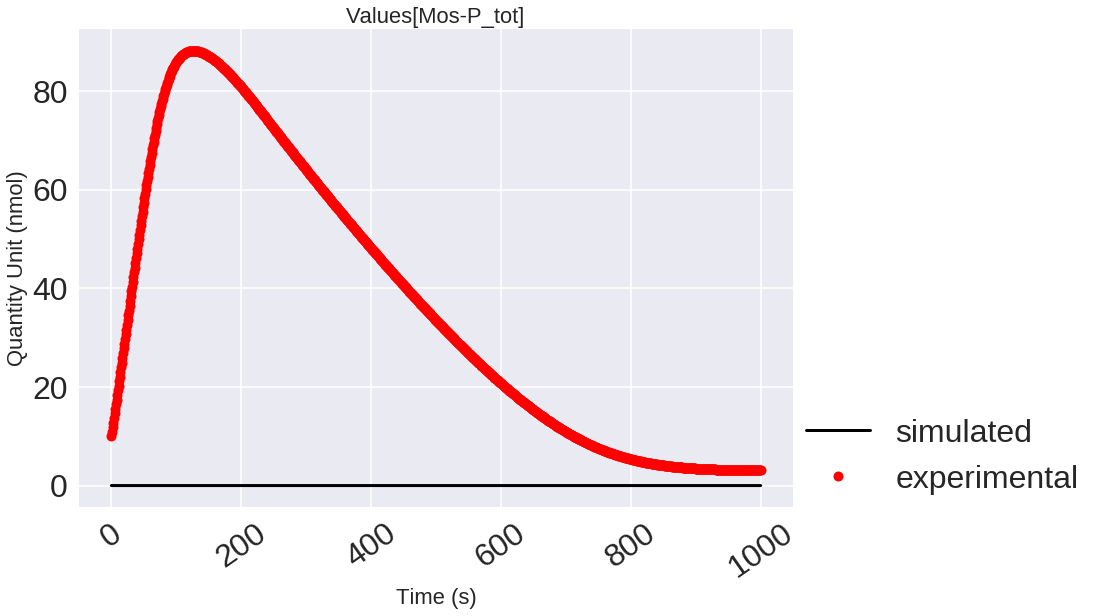

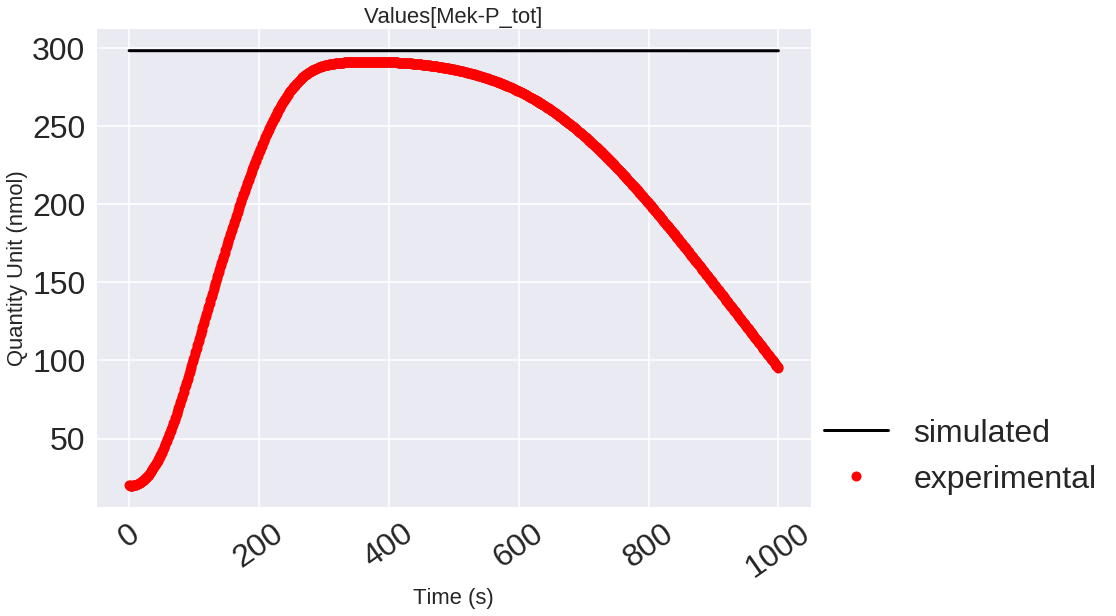

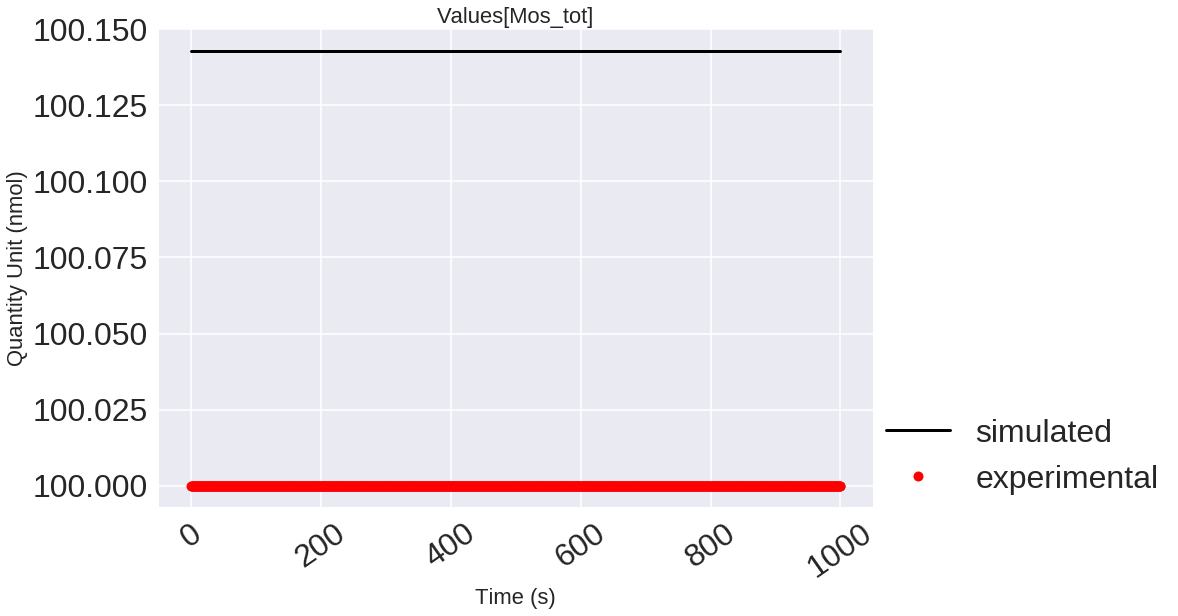

In [3]:
from PyCoTools.pycopi import ParameterEstimation 

report = 'parameter_estimation_data2.txt'
PE=ParameterEstimation(kholodenko_model,data1,method='GeneticAlgorithm',plot=True,
                       population_size = 50,number_of_generations= 300,report_name = report)

PE.write_config_template()
PE.setup()
PE.run()
PE.format_results()

# os.system('CopasiUI {}'.format(kholodenko_model))

Lets check the parameter estimation data:

In [ ]:
import pandas
print pandas.read_csv(PE.kwargs['report_name'],sep='\t').transpose()

# Visualization 
Use the `Plot` keyword to visualize the data

In [ ]:
from PyCoTools.pycopi import ParameterEstimation 

report = 'parameter_estimation_data2.txt'
PE=ParameterEstimation(kholodenko_model,[data1,data2],
                      method='GeneticAlgorithm',
                      population_size = 20,
                      number_of_generations = 20,
                      report_name = report,
                      plot=True)
PE.setup()
PE.run()


An alternative is to simply insert the parameters and the open the model using the UI and simulate manually using current solution statistics.

In [ ]:
import PyCoTools
import os
import pandas

pe_data = pandas.read_csv(report,sep='\t')

print pe_data

PyCoTools.pycopi.InsertParameters(kholodenko_model,parameter_path = report, index = 0)

os.system('CopasiUI {}'.format(kholodenko_model))

